# Termoelasticidad lineal

Nota: a este documento no lo podremos ejecutar de manera dinámica con Binder, sólo lo podrán correr si tienen instalado:

- Python 3.5 o más nuevo instalado.
- [Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html).
- [FEniCS](https://fenicsproject.org/).

### Referencias

- También sacamos el ejemplo del siguiente [enlace](https://comet-fenics.readthedocs.io/).

## Introducción

En este tutorial comenzaremos a trabajar con problemas acoplados, esto significa que implementaremos dos (o más) problemas físicos diferentes, por esta razón en los últimos años se los suele llamar simulaciones multifísicas. Esto significa que habrá muchas situaciones en que debemos resolver un sistema de Ecuaciones Diferenciales en Derivadas Parciales (sistema de PDEs) que gobiernan físicas bien diferentes y que están acopladas por alguna variable que las relaciona. Como ejemplos clásicos podemos mencionar la combinación de:

- la ecuación del calor con la de elasticidad
- la del problema eléctrico con la de calor ([enlace](https://github.com/rirastorza/RFA-tutorial))
- las ecuaciones de advección–difusión-reacción de dos especies químicas ([enlace](https://fenicsproject.org/pub/tutorial/html/._ftut1010.html#ftut1:reactionsystem))

### Termoelasticidad lineal

Comenzaremos por un caso de mucho interés en mecánica la denominada **termoelasticidad**. Sabemos que calentar o enfriar un material produce una expansión o contracción, respectivamente. Consideremos el caso de deformación *isotrópica* y en estado *estacionario*, es decir, la deformación es igual en las tres direcciones y esperamos suficiente tiempo a una determinada temperatura. En palabras, a la deformación mecánica debida a las solicitudes de la pieza le sumaremos la deformación debida a la expansión (o contracción) térmica producida por el aumento (o disminución) de la temperatura. En ecuaciones, debemos modificar la ley de Hooke y agregar el término de expansión térmica:

$$\varepsilon_{T} = \alpha \left(T-T_{0}\right)I \tag{1}$$.

Noten que esta ecuación es una aproximación de una serie de Taylor de la deformación $\varepsilon_{T}$ que llega sólo hasta el término lineal, por eso el título es termoelasticidad lineal. El coeficiente $\alpha$ es el de **dilatación lineal térmica**, si estamos trabajando en 3D será un coeficiente volumétrico $\alpha_{v}$, aunque nos encontraremos muy a menudo con el lineal $\alpha_{\ell}$. Si es el medio es isotrópico $\alpha_{v} = 3\alpha_{\ell}$.

La *ley de Hooke* considerando ahora el término de dilatación térmica será:

$$\sigma = 2\mu\varepsilon+\lambda tr\left(\varepsilon \right)  I -\alpha \left(3\lambda+ 2\mu\right)\left(T-T_{0}\right)I \tag{2}$$

Aquí aparecen el acoplamiento entre las variables tensión, deformación, desplazamiento y temperatura. Si quisieramos resolverlo deberíamos acoplar todo al mismo tiempo, tal como figura en el trabajo de [Farhat y otros](https://www.sciencedirect.com/science/article/pii/004578259190102C):

$$\rho \ddot{u} = \nabla \cdot \sigma + b \tag{3}$$

aquí $b$ es la fuerza debido al peso de la pieza (body force) y $\rho$ es la densidad, tal como vimos en el [tutorial de elastodinámica](https://github.com/rirastorza/Intro2FEM/blob/master/Problemas_dependientes_del_tiempo/Problema_elastodinamico.ipynb).

$$c \dot{T} = \nabla \cdot k \nabla T -\alpha \left(3\lambda+2\mu\right)T_{0}tr\left(\dot{\varepsilon}\right) + f \tag{4}$$

en este caso estamos utilizando la misma relación que en el [tutorial de ecuación de calor](https://github.com/rirastorza/Intro2FEM/blob/master/Problemas_dependientes_del_tiempo/Introduccion_problema_termico.ipynb). La diferencia aquí es que agregamos un término $\alpha \left(3\lambda+2\mu\right)T_{0}tr\left(\dot{\varepsilon}\right)$, esto sale de plantear que el cambio de entropía del sistema con la temperatura (ver término de expansión volumétrica [acá](https://authors.library.caltech.edu/25018/6/TOE05.pdf) y [acá](http://homepages.engineering.auckland.ac.nz/~pkel015/SolidMechanicsBooks/Part_IV/Chapter_2_Applications/PDF/02_Thermomech_Applications_02_Thermoelasticity.pdf)) se debe ahora al calor y al cambio de volumen. En la Ec. (4) el término $f$ es una fuente de calor. Hemos omitido aquí la relación entre deformación y desplazamiento $\varepsilon = \frac{1}{2}\left(\nabla u + \nabla u^{T}\right)$.

Pasando un poco en limpio, aquí debemos resolver dos PDEs Ec. (3) y (4) y tenemos dos variables $u$ y $T$, uno es un campo vectorial y el otro uno escalar.

En el **caso estacionario**, el problema más simple es acoplar débilmente los campos mencionados, esto significa esencialmente, desacoplarlos y pensar que un aumento de la temperatura provoca una expansión, calcular el desplazamiento debido a esa expansión y el peso de la pieza. Por lo tanto, arreglamos un poco las Ecs. (3) y (4) reemplazándolas por:

$$\nabla \cdot k \nabla T = 0 \tag{5}$$

hemos tirado todos los términos dependientes del tiempo (también el que depende de $\dot{\varepsilon}$ que acoplaba la Ec. (4) con la (3)) y también el de la fuente de calor $f$. Con esta ecuación calculamos la temperatura. Las mecánicas quedan parecidas, con la diferencia que la ley de Hooke está modificada por la expansión térmica.

$$\nabla \cdot \sigma + b = 0 \tag{6}$$

$$\sigma = 2\mu\varepsilon+\lambda tr\left(\varepsilon \right)  I -\alpha \left(3\lambda+ 2\mu\right)\left(T-T_{0}\right)I \tag{7}$$

$$\varepsilon = \frac{1}{2}\left(\nabla u + \nabla u^{T}\right)\tag{8}$$

Con estas tres ecuaciones calculamos cuánto se desplazó.

### Ejemplo

Todo el código está subido a la carpeta ejemplos con el nombre de *ejemplo22.py*.


[<img src="imagen1.png" width="400"/>](imagen1.png)

El problema es el mostrado en la figura: una barra empotrada en ambos lados (rígidos) y sometida a una temperatura ($T_{0}+\Delta T$) en la parte inferior. Supongamos que la barra tiene 5 mm y de ancho 0.3 mm. Como siempre, definimos algunos parámetros y luego la malla.

In [1]:
from __future__ import print_function
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

L, H = 5, 0.3
mesh = RectangleMesh(Point(0., 0.), Point(L, H), 100, 10, "crossed")


Creamos las funciones para los bordes.

In [3]:
def laterales(x, on_boundary):
    return (near(x[0], 0) or near(x[0], L)) and on_boundary
def abajo(x, on_boundary):
    return near(x[1], 0) and on_boundary
def arriba(x, on_boundary):
    return near(x[1], H) and on_boundary

Sabemos que la formulación variacional para el [problema térmico estacionario](https://github.com/rirastorza/Intro2FEM/blob/master/Elementos_finitos_en_2D/termico2D.ipynb) es la resolución de la ecuación de Poisson:

$$\int_{\Omega}k\nabla T \ \cdot \nabla v  da =\int_{\Omega} f \ v \ da$$

aquí $f$ es igual a cero.


Calling FFC just-in-time (JIT) compiler, this may take some time.


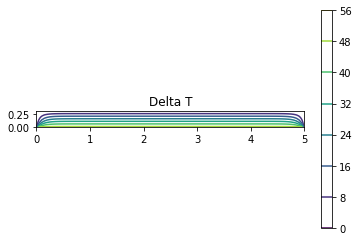

In [7]:
VT = FunctionSpace(mesh, "CG", 1)#Lagrange de orden 1 (temperatura es un escalar)
T_, dT = TestFunction(VT), TrialFunction(VT) #Ojo T_ es la función de test (v)
Delta_T = Function(VT, name="Incremento de la temperatura")
k=0.1 #Da lo mismo cualquier valor que ponga en estado estacionario.
aT = k*dot(grad(dT), grad(T_))*dx
LT = Constant(0)*T_*dx

bcT = [DirichletBC(VT, Constant(50.), abajo), 
       DirichletBC(VT, Constant(0.), arriba),
       DirichletBC(VT, Constant(0.), laterales)]
solve(aT == LT, Delta_T, bcT)#Pone en Delta_T el valor despejado
plt.figure()
p = plot(Delta_T,title="Delta T", mode="contour")
plt.colorbar(p)
plt.show()

Resolvimos entonces como se distribuye la temperatura en toda la barra. Note que le pusimos un cambio de temperatura $\Delta T = 50$ °C. Note además, que tal como está planteado el problema, con cualquier conductividad térmica dará lo mismo.

Ahora tenemos que resolver cuánto se va a expandir, y simultánemente el desplazamiento por el propio peso de la barra.

Definimos las constantes: 

In [8]:
E = Constant(50e3)
nu = Constant(0.2)
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
alpha = Constant(1e-5)
rho_g = 1e-3
b = Constant((0, -rho_g))

Y ahora definimos las Ecs. (7) y (8). Notar que la función de la tensión debe contener también la temperatura.

In [9]:
def eps(v):
    return sym(grad(v))
def sigma(v, dT):
    return (lmbda*tr(eps(v))- alpha*(3*lmbda+2*mu)*dT)*Identity(2) + 2.0*mu*eps(v)

Ahora debemos definir el campo vectorial que será la función de prueba para el desplazamiento.

In [10]:
Vu = VectorFunctionSpace(mesh, 'CG', 2) #Es una tensor
du = TrialFunction(Vu)
u_ = TestFunction(Vu)#Ojo esta es la función test

La formulación variacional de problema mecánico como ya lo hemos aprendido en el [tutorial de elasticidad](https://github.com/rirastorza/Intro2FEM/blob/master/Elementos_finitos_en_2D/ElasticidadLineal2D.ipynb): 

$$ \int_{\Omega} \sigma : \underbrace{\nabla w}_{\varepsilon\left(w\right)} \ dx-\int_{\partial\Omega_{N}}\underbrace{h}_{\sigma \cdot n} w \ ds - \int_{\Omega} bw \ dx = 0.$$

aquí la función de prueba la llamamos $w$, en el código u_. Note que utilizaremos una versión todavía más simple, porque las condiciones de borde son de Dirichlet.

$$ \int_{\Omega} \sigma : \underbrace{\nabla w}_{\varepsilon\left(w\right)} \ dx = \int_{\Omega} bw \ dx.$$


In [12]:
Wint = inner(sigma(du, Delta_T), eps(u_))*dx #Delta_T ya es  conocida del anterior
aM = lhs(Wint)
LM = rhs(Wint) + inner(b, u_)*dx
bcu = DirichletBC(Vu, Constant((0., 0.)), laterales)

Finalmente, resolvemos y dibujamos.

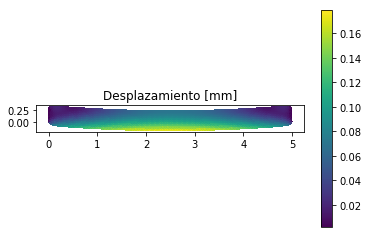

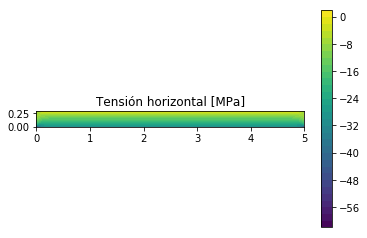

In [13]:
u = Function(Vu, name="Desplazamiento")
solve(aM == LM, u, bcu)
plt.figure()
p = plot(1e3*u,title="Desplazamiento [mm]", mode="displacement")
plt.colorbar(p)
plt.figure()
p = plot(sigma(u, Delta_T)[0, 0],title="Tensión horizontal [MPa]")
plt.colorbar(p)
plt.show()